# *contents*

- 加载数据
- 最大回撤和回撤期

<font color=red>*注意：A股一部分券商的客户端，处理前复权的方式存在以下错误：*
- 分红时，它们直接把前面交易日的OHLC都减去相同的数值！
- 分红、送股时，计算方式更是错上加错！
</font>

In [1]:
%matplotlib inline
import logging
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import helper
import pprint
import log_setup

helper.chinese_font_setup()
log_setup.setup()

In [2]:
datainfo, datainfo_abbr = helper.datafiles_info_v2()
datainfo

{'510050.SH': DataInfo(code='510050.SH', name='上证50ETF', abbr='SZ50ETF,', path='./datafiles/510050.SH_2005-02-23_2023-04-25.xlsx', first='2005-02-23', last='2023-04-25'),
 '510300.SH': DataInfo(code='510300.SH', name='沪深300ETF', abbr='HS300ETF,', path='./datafiles/510300.SH_2012-05-28_2023-04-25.xlsx', first='2012-05-28', last='2023-04-25'),
 '510500.SH': DataInfo(code='510500.SH', name='中证500ETF', abbr='ZZ500ETF,', path='./datafiles/510500.SH_2013-03-15_2023-04-25.xlsx', first='2013-03-15', last='2023-04-25'),
 '159915.SZ': DataInfo(code='159915.SZ', name='创业板ETF', abbr='CYBETF,', path='./datafiles/159915.SZ_2011-12-09_2023-04-25.xlsx', first='2011-12-09', last='2023-04-25'),
 '159949.SZ': DataInfo(code='159949.SZ', name='创业板50ETF', abbr='CYB50ETF,', path='./datafiles/159949.SZ_2016-07-22_2023-04-25.xlsx', first='2016-07-22', last='2023-04-25'),
 '588000.SH': DataInfo(code='588000.SH', name='科创50ETF', abbr='KC50ETF,', path='./datafiles/588000.SH_2020-11-16_2023-04-25.xlsx', first='202

In [3]:
def build_big_df():
    series = []
    keys = []
    for di in datainfo.values():
        df = pd.read_excel(di.path, header=0, index_col=0)
        logging.info('{} {}'.format(di.name, df.shape))
        keys.append(di.code)
        series.append(df.close)
    df = pd.concat(series, axis=1, keys=keys)
    logging.info('result df shape: {}'.format(df.shape))
    return df

df = build_big_df()
df.describe()

[2023-04-27 23:30:50,398] [INFO]	[1009832064.py:6:build_big_df] 上证50ETF (4420, 7)
[2023-04-27 23:30:50,751] [INFO]	[1009832064.py:6:build_big_df] 沪深300ETF (2655, 7)
[2023-04-27 23:30:51,064] [INFO]	[1009832064.py:6:build_big_df] 中证500ETF (2459, 7)
[2023-04-27 23:30:51,491] [INFO]	[1009832064.py:6:build_big_df] 创业板ETF (2763, 7)
[2023-04-27 23:30:51,767] [INFO]	[1009832064.py:6:build_big_df] 创业板50ETF (1643, 7)
[2023-04-27 23:30:51,876] [INFO]	[1009832064.py:6:build_big_df] 科创50ETF (594, 7)
[2023-04-27 23:30:52,190] [INFO]	[1009832064.py:6:build_big_df] 黄金ETF (2372, 7)
[2023-04-27 23:30:52,268] [INFO]	[1009832064.py:6:build_big_df] 双创50ETF (440, 7)
[2023-04-27 23:30:52,333] [INFO]	[1009832064.py:6:build_big_df] A50ETF (357, 7)
[2023-04-27 23:30:52,364] [INFO]	[1009832064.py:10:build_big_df] result df shape: (4420, 9)


,510050.SH,510300.SH,510500.SH,159915.SZ,159949.SZ,588000.SH,518880.SH,159781.SZ,159601.SZ
count,4420.000000,2655.000000,2459.000000,2763.000000,1643.000000,594.000000,2372.000000,440.000000,357.000000
mean,2.017500,3.362446,5.382457,1.852079,0.898278,1.269764,3.053285,0.712639,0.865006
std,0.762775,0.931155,1.199667,0.704466,0.303249,0.198064,0.584696,0.120683,0.070014
min,0.517918,1.813988,2.819713,0.598000,0.425000,0.909000,2.167000,0.534000,0.721000
25%,1.446302,2.777259,4.621834,1.356000,0.658000,1.078000,2.616000,0.616000,0.811000
50%,1.983732,3.428157,5.610480,1.761000,0.814000,1.267500,2.774000,0.663500,0.851000
75%,2.656780,3.953988,6.175000,2.354500,1.114000,1.432500,3.653000,0.843000,0.907000
max,3.905555,5.629466,10.218341,3.790000,1.585000,1.670000,4.378000,0.994000,1.036000


<Axes: title={'center': '收盘价 (扩缩股、分红调整后)'}, ylabel='Adjusted Close'>

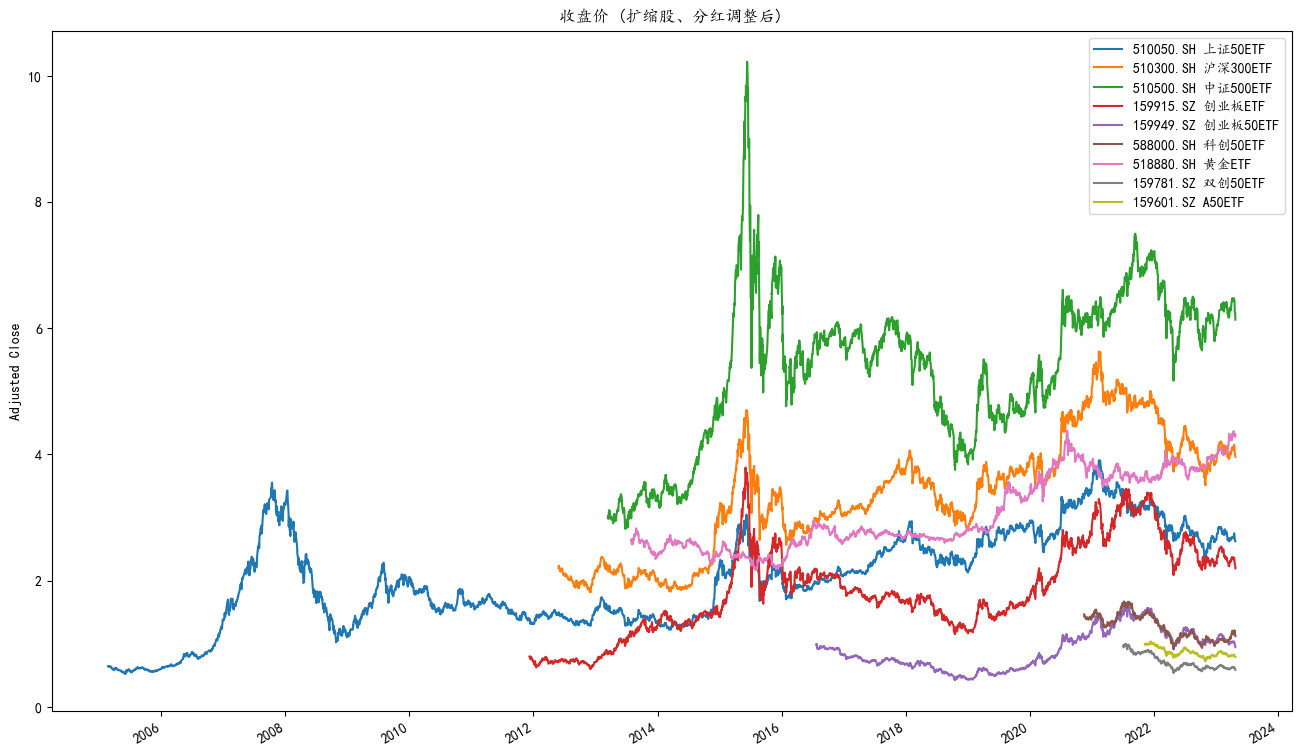

In [4]:
df.rename(
    columns=dict([ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo.values() ])
).plot(figsize=(16,10), ylabel='Adjusted Close', title='收盘价 (扩缩股、分红调整后)')

# *历史最大回撤 & 最大回撤天数*

In [5]:
def plot_drawdown(info, dataframe):

    n_samples = dataframe.shape[0]
    high_watermark_pos = np.zeros(n_samples, dtype=int)
    drawdown  = np.zeros(n_samples)
    duration  = np.zeros(n_samples, dtype=int)

    for i in range(1, n_samples):
        # past high
        prev_high_wm_pos = high_watermark_pos[i-1]
        prev_high_wm     = dataframe.cum_log_daily_ret[prev_high_wm_pos]
        if prev_high_wm > dataframe.cum_log_daily_ret[i]:
            # uses past high
            high_watermark_pos[i] = prev_high_wm_pos
        else:
            # current is new high
            high_watermark_pos[i] = i

        drawdown[i] = dataframe.cum_log_daily_ret[i] - dataframe.cum_log_daily_ret[ high_watermark_pos[i] ]
        if drawdown[i] >= 0:
            duration[i] = 0
        else:
            duration[i] = duration[i-1] + 1

    max_drawdown_end   = np.argmin(drawdown)
    max_drawdown_start = high_watermark_pos[max_drawdown_end]
    max_drawdown = np.exp2(drawdown[max_drawdown_end]) - 1

    max_duration_end   = np.argmax(duration)
    max_duration       = duration[max_duration_end]
    max_duration_start = max_duration_end - max_duration

    prices = dataframe.close

    years = np.array(dataframe.index.year)
    year_start_pos = np.where(years[:-1] != years[1:])[0] + 1
    year_labels = dataframe.index[year_start_pos].strftime('%Y')

    plt.figure(figsize=(13, 8), dpi=120)
    plt.title('{} {} [{}, {}]'.format(info.code, info.name, info.first, info.last))
    plt.plot(np.arange(n_samples), prices, color='tab:orange', label='收盘价 (扩缩股、分红调整后)')
    min_price, max_price = np.min(prices), np.max(prices)
    price_span = max_price - min_price
    plt.ylim(min_price - price_span * 0.15, max_price + price_span * 0.15)
    plt.gca().set_xticks(year_start_pos)
    plt.gca().set_xticklabels(year_labels, rotation=45)
    plt.ylabel('价格')

    aux_color = 'tab:blue'
    plt.vlines(x=[max_drawdown_end], ymin=prices[max_drawdown_end], ymax=prices[max_drawdown_start],
               color=aux_color, ls='--', lw=2, label='最大回撤:     {:.1f} %'.format(max_drawdown * 100))
    plt.hlines(y=[prices[max_drawdown_start]], xmin=max_drawdown_start, xmax=max_drawdown_end,
               color=aux_color, ls='--', lw=2)
    plt.hlines([prices[max_duration_start]], max_duration_start, max_duration_end,
               color=aux_color, ls=':', lw=2, label='最大回撤天数: {} 日'.format(max_duration))

    conf_dict = dict(
        xycoords='data', textcoords='offset points', fontsize=10, color='blue',
        arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", color=aux_color),
    )
    # max drawdown
    price = prices[max_drawdown_start]
    ymd   = prices.index[max_drawdown_start].strftime('%Y-%m-%d')
    plt.annotate('{:.4f} @ {}'.format(price, ymd),
                 xy=(max_drawdown_start, prices[max_drawdown_start]), xytext=(-30, 20), **conf_dict)
    price = prices[max_drawdown_end]
    ymd   = prices.index[max_drawdown_end].strftime('%Y-%m-%d')
    plt.annotate('{:.4f} @ {}'.format(price, ymd),
                 xy=(max_drawdown_end, prices[max_drawdown_end]), xytext=(-30, -30), **conf_dict)
    # max drawdown duration
    if max_duration_start != max_drawdown_start:
        price = prices[max_duration_start]
        ymd   = prices.index[max_duration_start].strftime('%Y-%m-%d')
        plt.annotate('{:.4f} @ {}'.format(price, ymd),
                     xy=(max_duration_start, prices[max_duration_start]), xytext=(-30, 20), **conf_dict)
    if max_duration_end != max_drawdown_end:
        price = prices[max_duration_end]
        ymd   = prices.index[max_duration_end].strftime('%Y-%m-%d')
        plt.annotate('{:.4f} @ {}'.format(price, ymd),
                     xy=(max_duration_end, prices[max_duration_end]), xytext=(-30, 20), **conf_dict)

    plt.legend(loc='lower right')

**离谱：** 有些ETF从历史最高点回撤，就没有回本过。。。

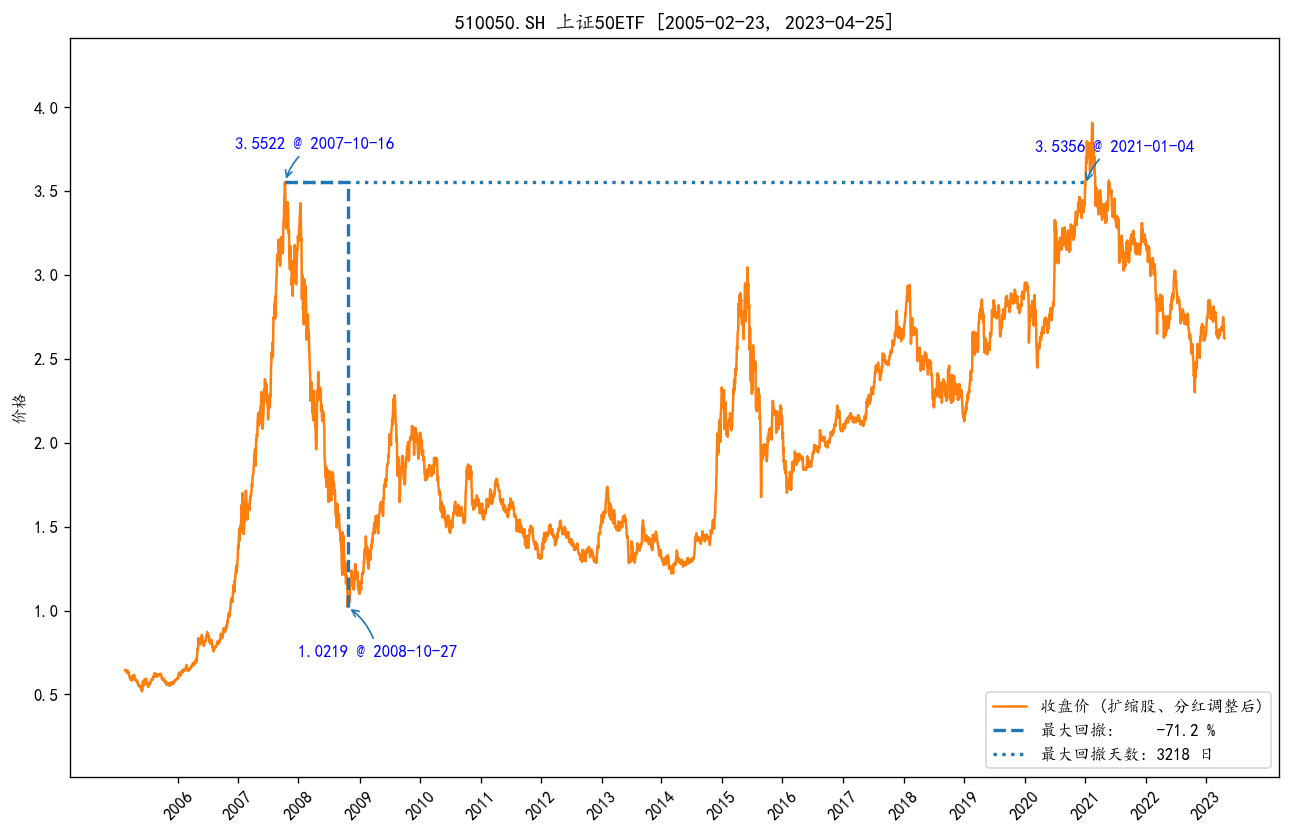

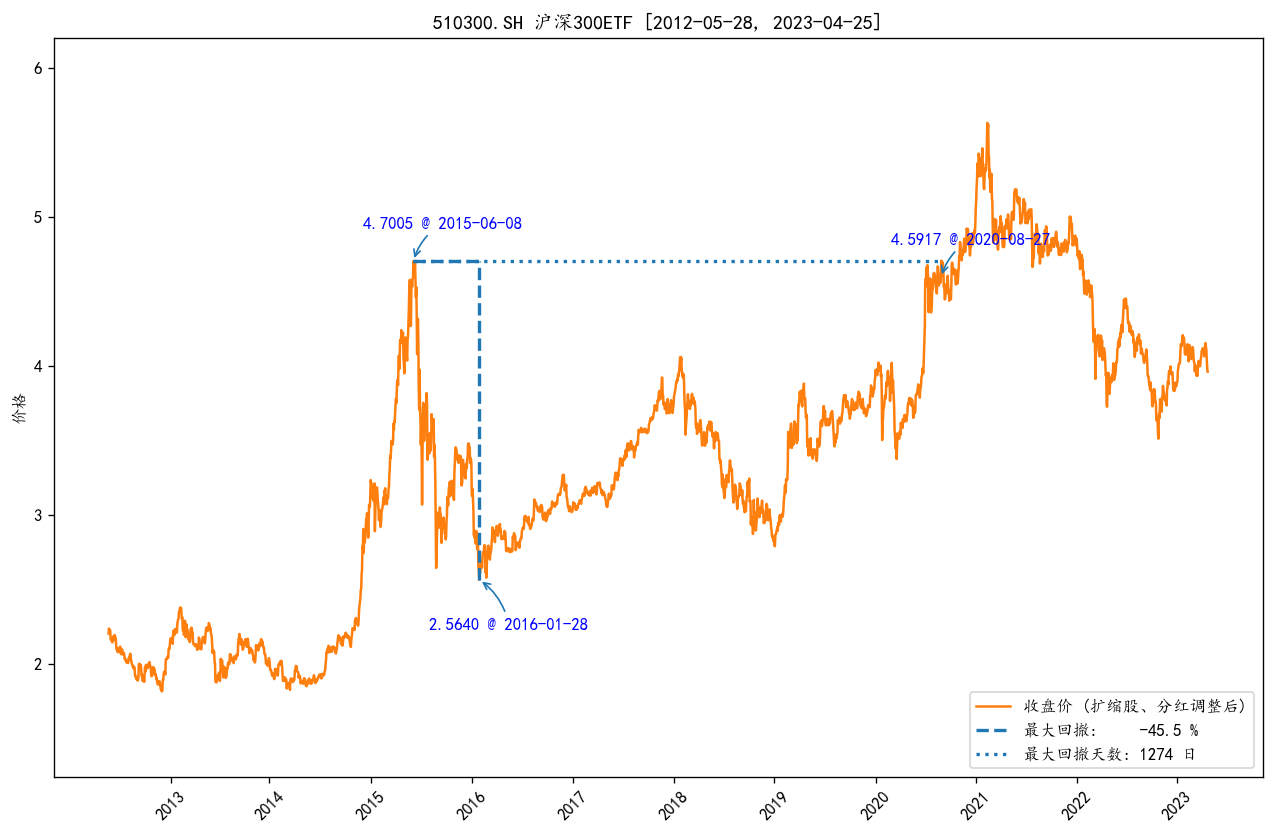

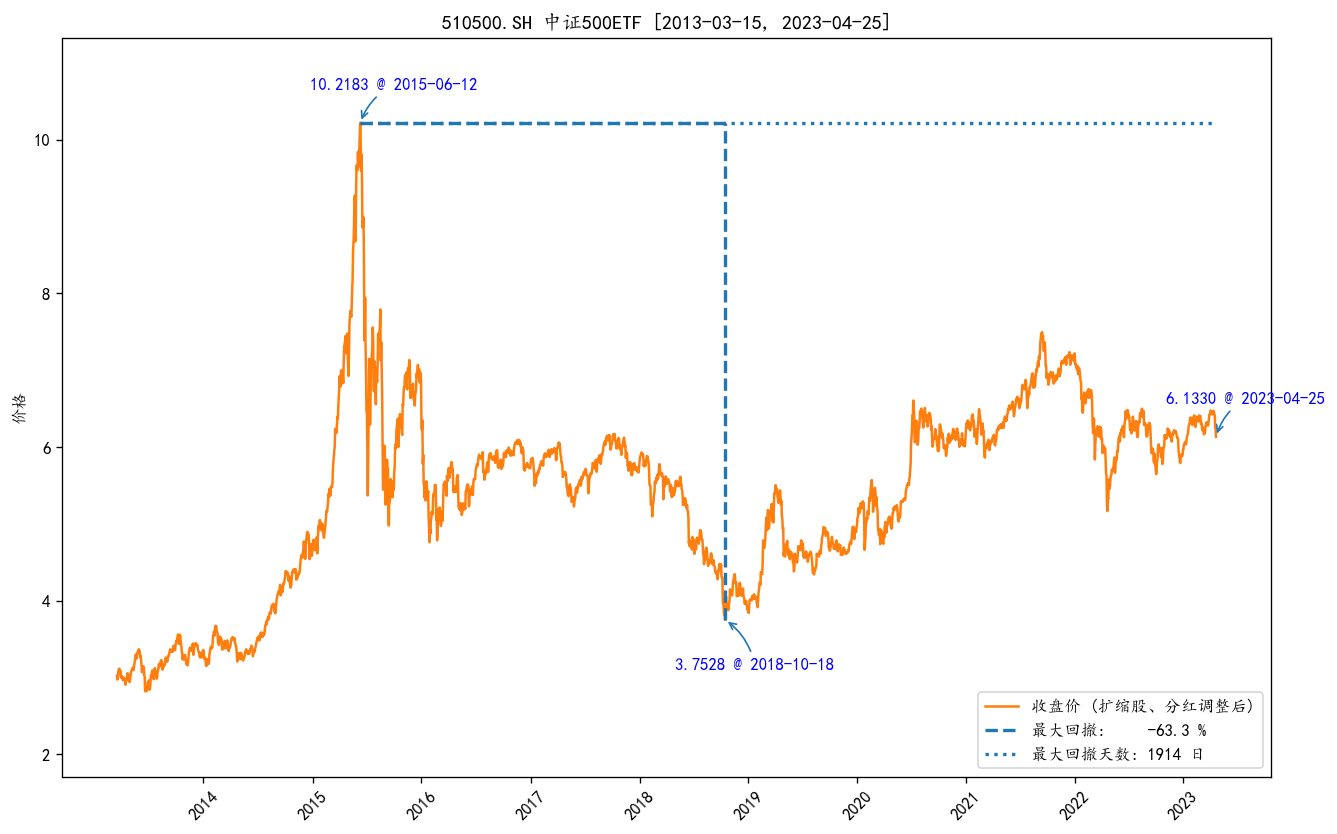

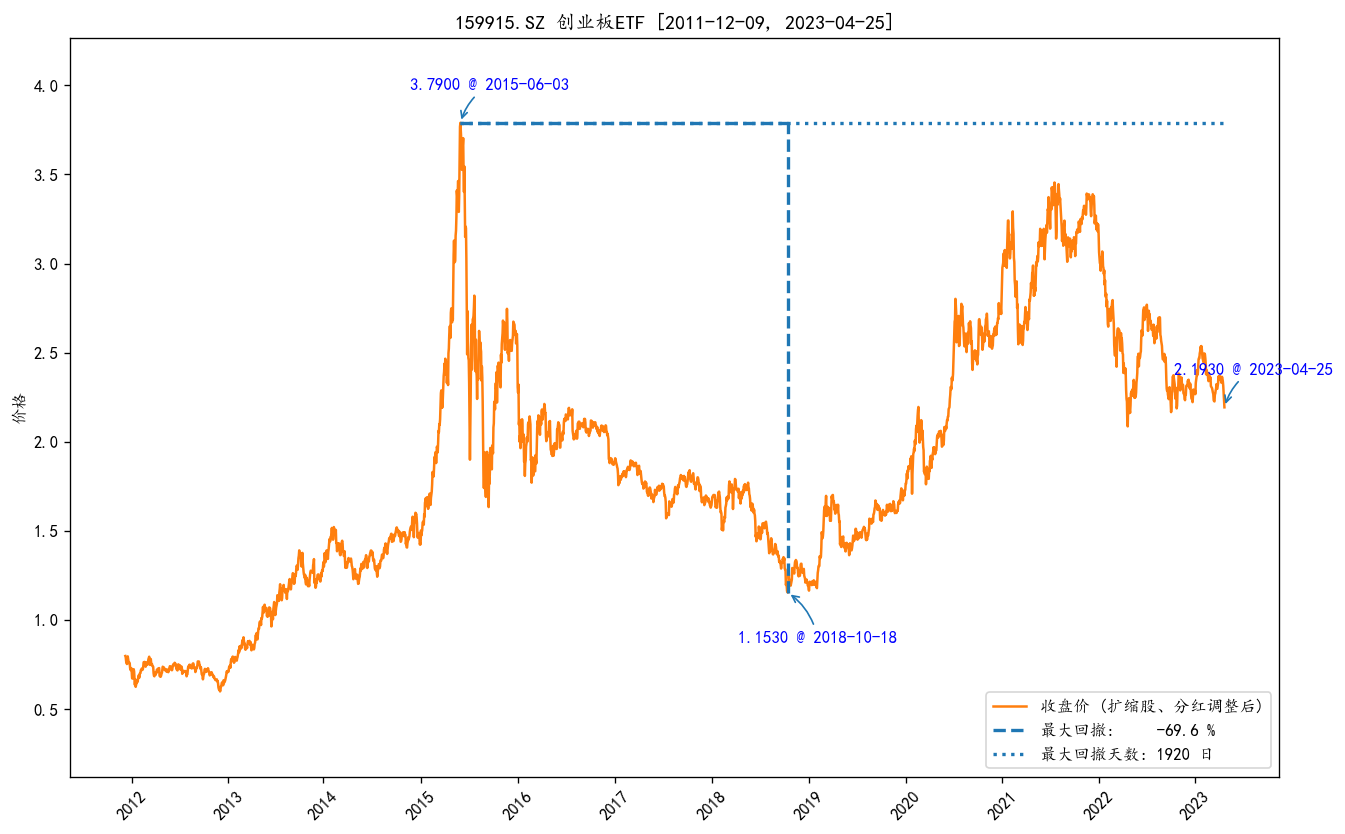

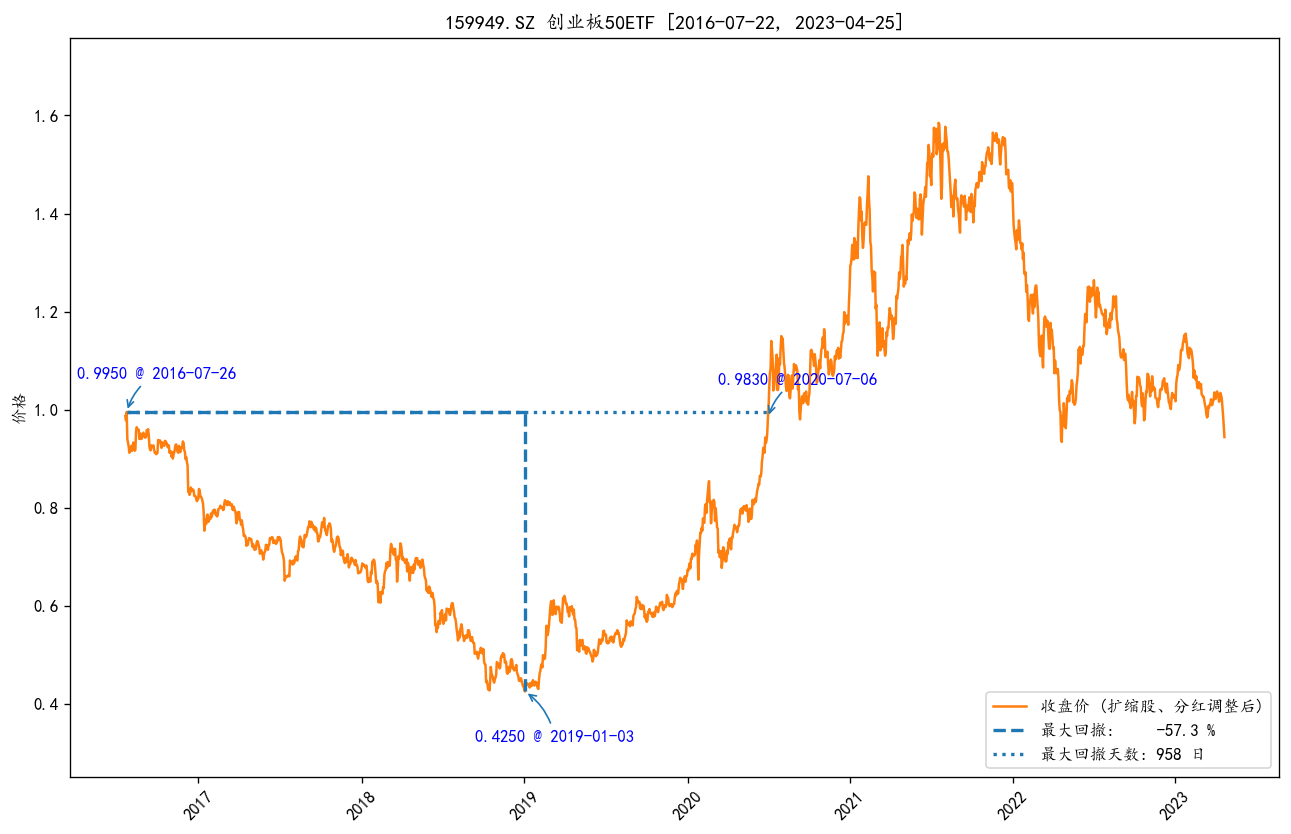

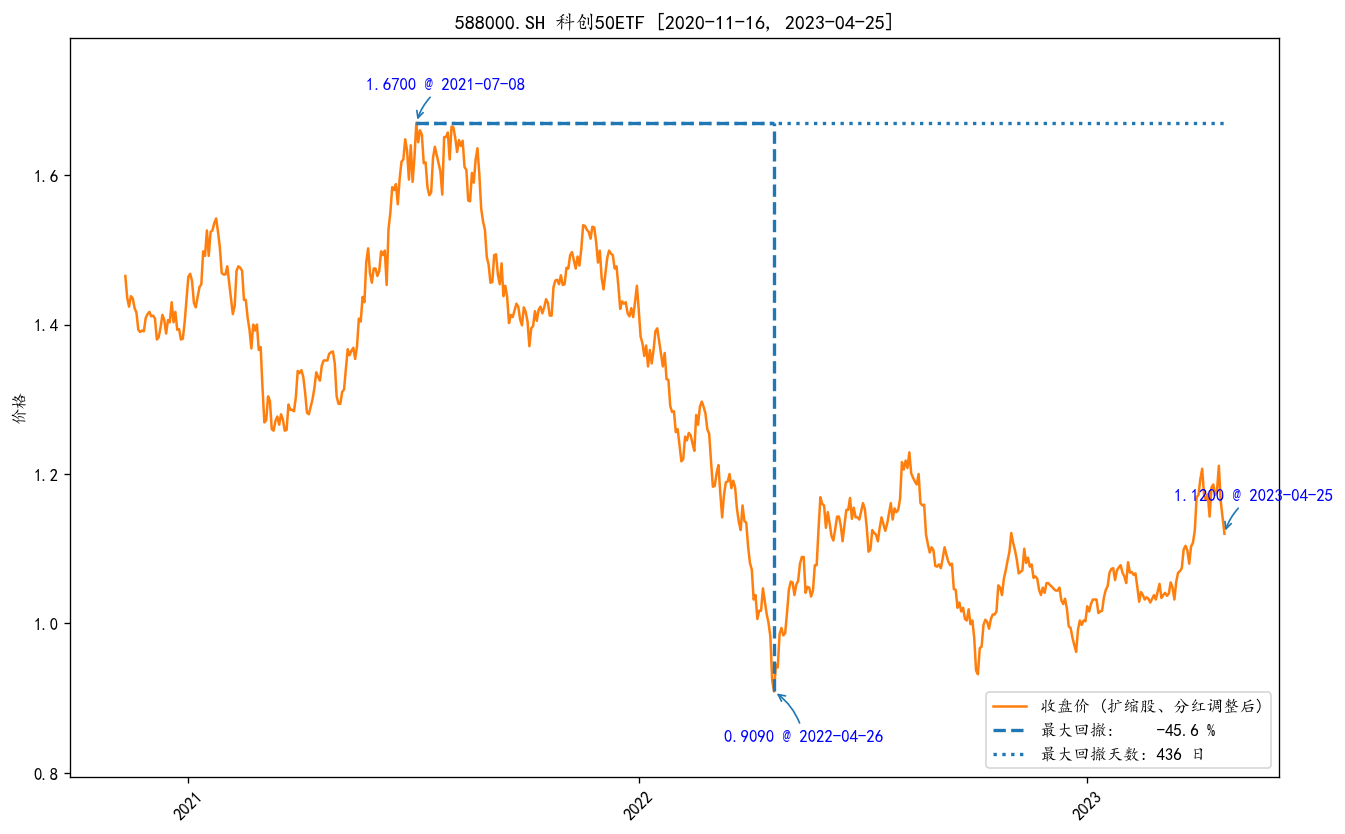

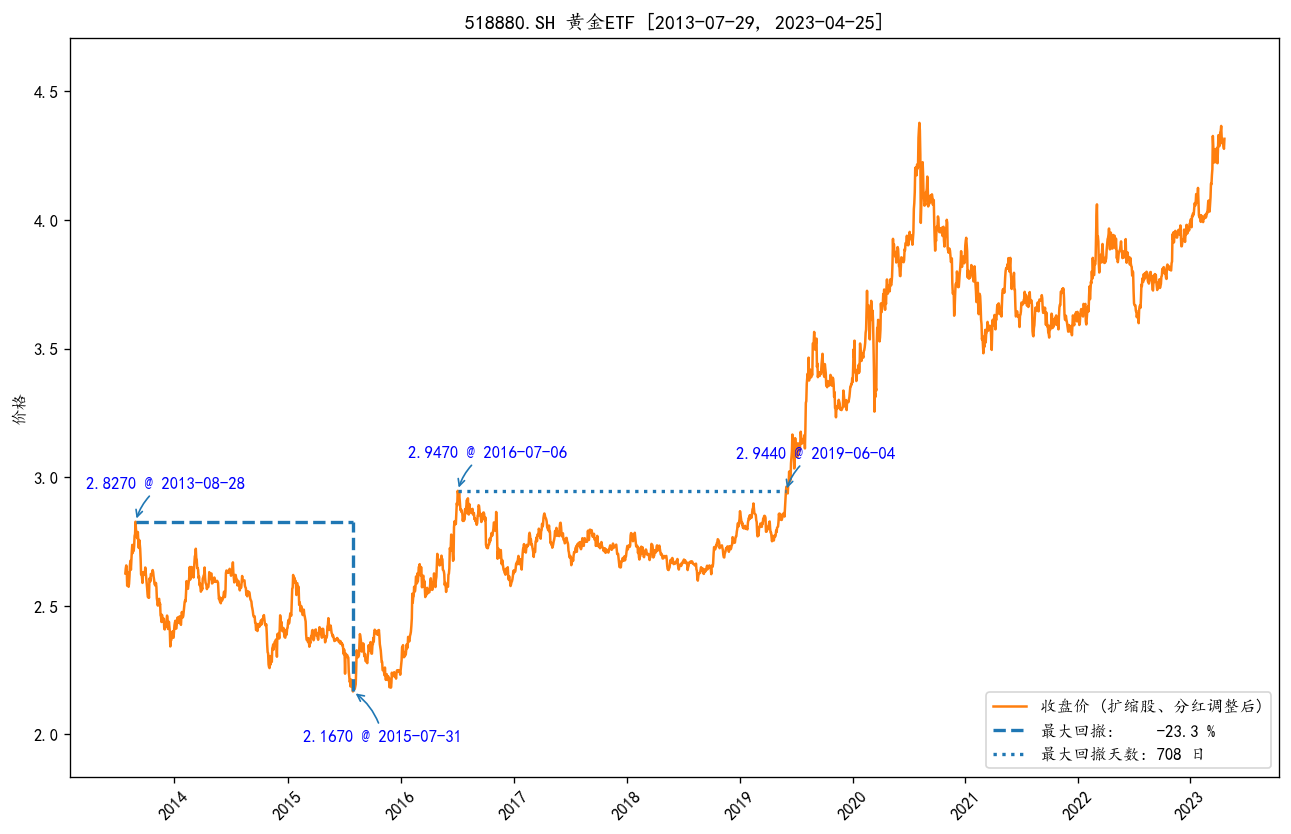

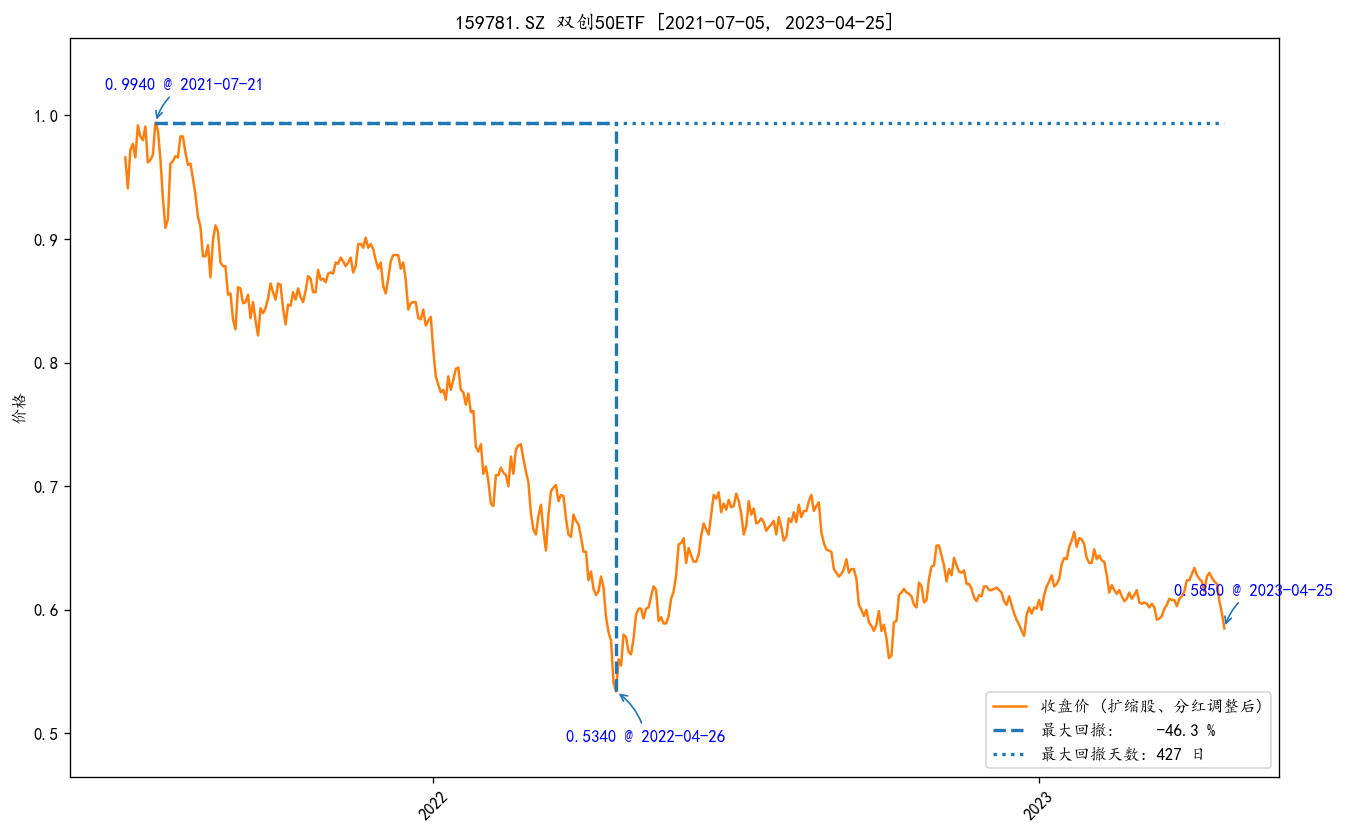

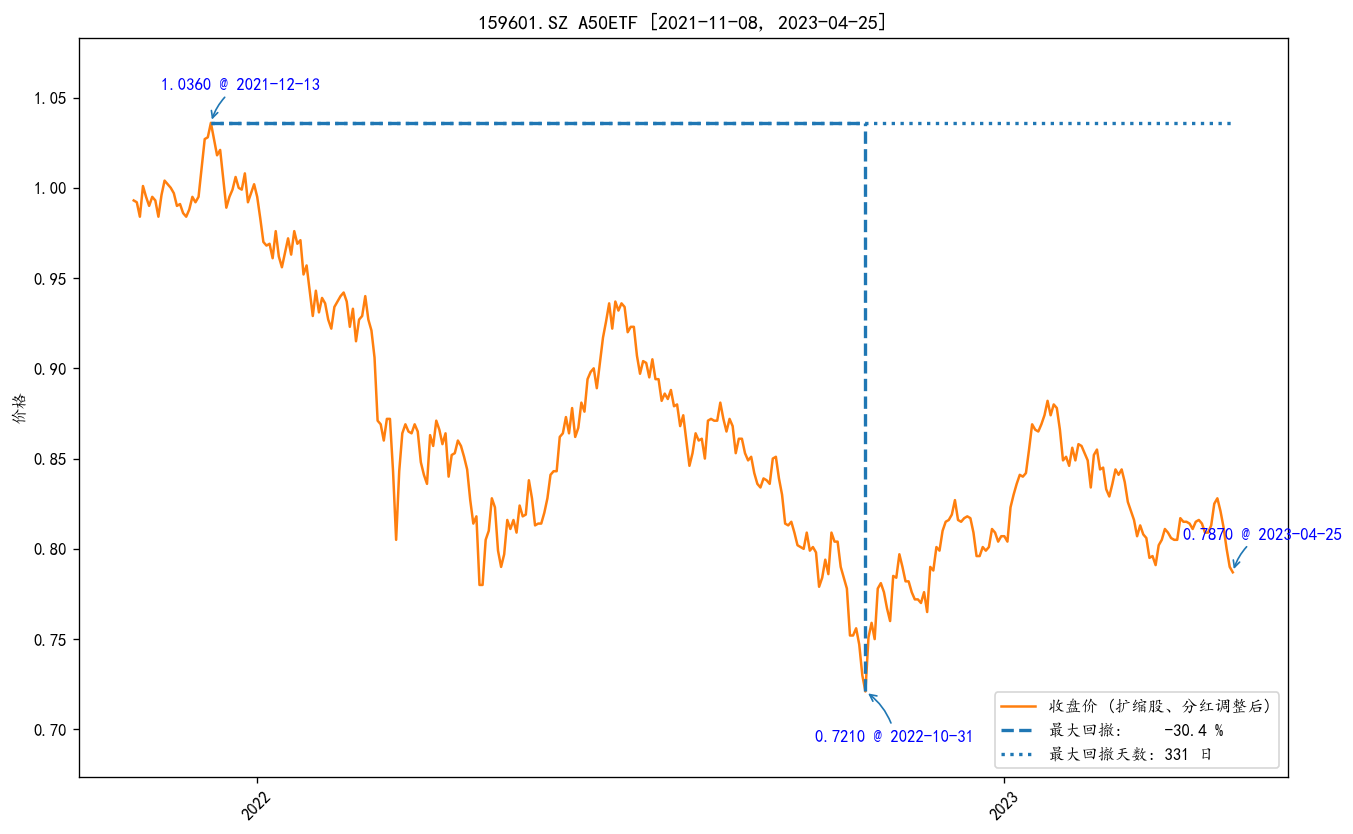

In [6]:
n_assets = len(datainfo)
for info in list(datainfo.values())[:]:
    dataframe = pd.read_excel(info.path, header=0, index_col=0)
    # pct_change() + cumsum() are not as accurate as log2() + cumsum()
    # e.g two adjacent 10% fall result in a 0.19 drawdown, not 0.2
    #    - 0.1 - 0.1 = - 0.2
    #    0.9 * 0.9 - 1 = - 0.19
    #dataframe['daily_ret']     = dataframe.close.pct_change()
    #dataframe['cum_daily_ret'] = dataframe.daily_ret.cumsum()

    # *NOTE*: logrithm using base 2
    dataframe['log_daily_ret']     = np.log2(dataframe.close / dataframe.close.shift(1))
    dataframe['cum_log_daily_ret'] = dataframe.log_daily_ret.cumsum()
    plot_drawdown(info, dataframe)

In [7]:
dataframe

,timestamp,open,high,low,close,amount,volume,log_daily_ret,cum_log_daily_ret
2021-11-08 01:30:00,1636335000,0.990,1.001,0.987,0.993,3616966912,3635689238,NaN,NaN
2021-11-09 01:30:00,1636421400,0.996,1.001,0.988,0.992,3501942784,3523894276,-0.001454,-0.001454
2021-11-10 01:30:00,1636507800,0.991,0.991,0.970,0.984,3452992000,3527465613,-0.011682,-0.013135
2021-11-11 01:30:00,1636594200,0.984,1.002,0.983,1.001,3631389952,3645440904,0.024712,0.011576
2021-11-12 01:30:00,1636680600,1.002,1.004,0.992,0.995,3430757888,3446579547,-0.008674,0.002903
...,...,...,...,...,...,...,...,...,...
2023-04-19 01:30:00,1681867800,0.828,0.829,0.820,0.821,96496424,117228965,-0.012249,-0.274411
2023-04-20 01:30:00,1681954200,0.822,0.822,0.809,0.812,97600712,120045711,-0.015902,-0.290314
2023-04-21 01:30:00,1682040600,0.813,0.813,0.799,0.800,112985448,139997287,-0.021480,-0.311794
2023-04-24 01:30:00,1682299800,0.800,0.801,0.785,0.790,113558560,143419213,-0.018147,-0.329941
